In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt

# load the qcodes path, until we have this installed as a package
import sys

qcpath = '/Users/alex/qdev/Qcodes'
if qcpath not in sys.path:
    sys.path.append(qcpath)

# force windows multiprocessing behavior on mac
import multiprocessing as mp
mp.set_start_method('spawn')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# spawn doesn't like function or class definitions in the interpreter
# session - had to move them to a file.
from toymodel import AModel, MockGates, MockSource, MockMeter

# no extra processes running yet
mp.active_children()

[]

In [3]:
# now create this "experiment"
model = AModel()
gates = MockGates('gates', model)
source = MockSource('source', model)
meter = MockMeter('meter', model)

from qcodes.station import Station
station = Station(gates, source, meter)

# could measure any number of things by adding to this list,
# but here we're just measuring one, the meter amplitude
# we can also create multiple measurement sets side-by-side,
# but only one is the default one stored in the station
measurement = station.set_measurement(meter['amplitude'])

# it's nice to have the key parameters be part of the global namespace
# that way they're objects that we can easily set, get, and slice
# this could be simplified to a station method that gathers all parameters
# and adds them all as (disambiguated) globals, printing what it did
# something like:
#   station.gather_parameters(globals())
c0, c1, c2, vsd = gates['chan0'], gates['chan1'], gates['chan2'], source['amplitude']

# check that a StorageServer is running
mp.active_children()

[<Process(Process-1, started daemon)>]

In [4]:
# we can get the measured quantities right now
measurement.get()

(0.117,)

In [5]:
# start a sweep (which by default runs in a seprarate process)
# the sweep values are defined by slicing the parameter object
# but more complicated sweeps (eg nonlinear, or adaptive) can
# easily be used instead
swp = measurement.sweep(c0[-20:20:0.1], 0.2, location='testsweep')
swp

In [6]:
# now there should be two processes running, StorageServer and a sweep
mp.active_children()

[<Process(Process-2, started daemon)>, <Process(Process-1, started daemon)>]

In [10]:
# bring the sweep data into the main process and display it as numbers
swp.sync_live()
# swp.read()
swp.data

{'amplitude': array([ 0.117,  0.117,  0.115,  0.111,  0.106,  0.099,  0.092,  0.085,
         0.077,  0.071,  0.064,  0.058,  0.053,  0.048,  0.044,  0.04 ,
         0.037,  0.034,  0.031,  0.029,  0.027,  0.025,  0.023,  0.022,
         0.02 ,  0.019,  0.018,  0.017,  0.016,  0.015,  0.014,  0.013,
         0.013,  0.012,  0.011,  0.011,  0.01 ,  0.01 ,  0.01 ,  0.009,
         0.009,  0.008,  0.008,  0.008,  0.007,  0.007,  0.007,  0.007,
         0.006,  0.006,  0.006,  0.006,  0.006,  0.007,  0.007,  0.007,
         0.007,  0.008,  0.008,  0.008,  0.009,  0.009,  0.01 ,  0.01 ,
         0.01 ,  0.011,  0.011,  0.012,  0.013,  0.013,  0.014,  0.015,
         0.016,  0.017,  0.018,  0.019,  0.02 ,  0.022,  0.023,  0.025,
         0.027,  0.029,  0.031,  0.034,  0.037,  0.04 ,  0.044,  0.048,
         0.053,  0.058,  0.064,  0.071,  0.077,  0.085,  0.092,  0.099,
         0.106,  0.111,  0.115,  0.117,  0.117,  0.117,  0.115,  0.111,
         0.106,  0.099,  0.092,  0.085,  0.077,  0.

<IPython.core.display.Javascript object>


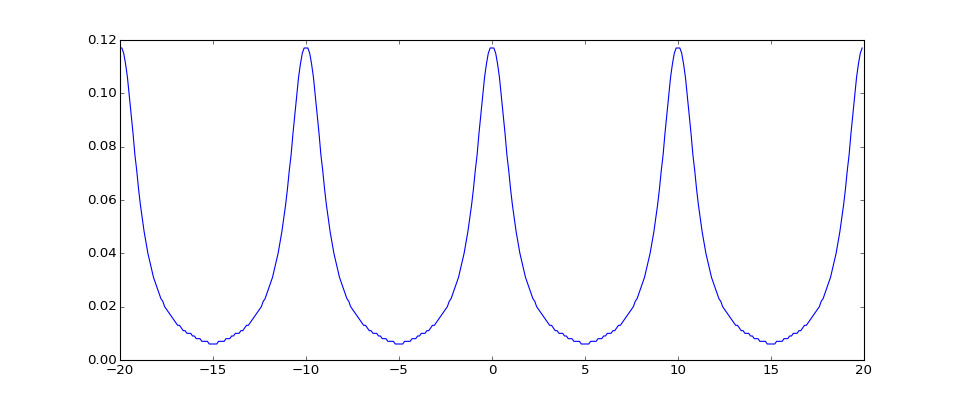

In [20]:
# plot (can also be done repeatedly while the sweep is running)
# next up: create an active plot that will update itself automatically
# (via javascript, so the main python stays accessible) as long as the sweep is running
# as well as provide some nicer styling and labeling defaults
swp.sync_live()
plt.figure(figsize=(12, 5))
plt.plot(swp['chan0'], swp['amplitude'])
plt.show()

In [21]:
swp2 = measurement.sweep(c1[-15:15:1], 1, c0[-15:15:.5], 0.03, location='test2d')

<IPython.core.display.Javascript object>


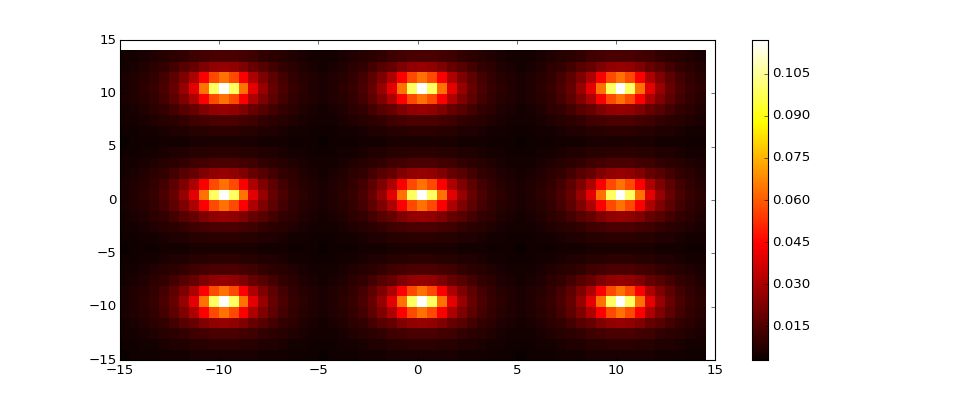

In [33]:
# again, can call this repeatedly while the plot is running
swp2.sync_live()
import numpy.ma as ma
plt.figure(figsize=(12, 5))
# pcolormesh needs NaN masked out or it barfs
plt.pcolormesh(ma.masked_invalid(swp2['chan0']),
               ma.masked_invalid(swp2['chan1']),
               ma.masked_invalid(swp2['amplitude']),
               cmap=plt.cm.hot)
plt.colorbar()
plt.show()

In [32]:
# I obviously have a lot to figure out about matplotlib...
# calling the above redraws constantly to "live update"
# generates warnings after a while about too many open figures
plt.close('all')